# Timeseries Forecasting for Building Experts Part 2: Trend Forecasting

In building science and building management, people always want to know what their data is going to look like in the future. This can tell you critical information about equipment operation, resource consumption, and energy usage. In this post we're going to tackle timeseries forecasting using Facebook's Prophet model. This post is perfect for building experts (engineers, data analysts, data scientists) who want to predict how their sensors or equipment will behave in the future 🧙‍♀️🔮.

On the last episode of Dragon Ball Z ([the last post of this little data science blog](https://medium.com/onboard-blog/feature-selection-and-timeseries-forecasting-24067e0038e3)), we did a bit of the old feature selection, looking for features that might predict chilled water supply flow, a measure of the chilled water being supplied to an HVAC system. 

<div>
    <figure style="width:60%;padding:20px">
        <img src="https://i.giphy.com/media/gp3f3KQWwYETbzCGOI/giphy.webp" />
        <figcaption style="text-align:left;font-size:9pt;width:50%"> <i>Vegeta (you) and Goku (me), teaming up to learn about timeseries forecasting (but also you could be Goku if you want and my mom put some capri suns in the fridge if you want one).</i> </figcaption>
    </figure>
</div>
<br />

The feature we found in the last post was "operation time", coded for when the building is operational (M-F, 10am-midnight) or non-operational (all other times). Now that we have a plausible feature that could contribute to chilled water consumption, let's develop a forecasting model, which can predict what the future timeseries stream might look like.

Bit of a warning: it gets a bit heady in this one. I'm gonna rate this a 4/5 on a technical level. I'll try to keep it not so nerdy so you don't fall asleep or zone out, and I'll give links to documentation as we go so you can go read more if you want. I really think the code itself should be accessible regardless of your technical knowledge at a machine learning/math-y level, so if you're relatively competent at Python, you should def be able to follow along without too much trouble.

Last thing: if you want to follow along interactively, you can do so on [colab](https://githubtocolab.com/onboard-data/notebooks/blob/dev/06_Forecasting_Part_2.ipynb), but you'll need to [get access to our API and sandbox](https://www.onboarddata.io/sandbox). You can use these to your heart's content to mess around with real building data, like the kind we're demonstrating here.

## Data Wrangling

The first step, as always: load the data, and clean/format it the way Prophet wants. Prophet always wants the timeseries data (our key variable of interest, chilled water supply flow) to be labeled as `y`, and the timestamp to be labeled `ds` (for "datestamp"). Here we also include our extra feature, `operation` (times of normal business operation), since last time we saw this as the most likely variable at our disposal as carrying predictive weight for our `y`.

In [422]:
import numpy as np
import pandas as pd
from onboard.client import OnboardClient
try: # for this you can either create a key.py file with one line: api_key = 'your api key here'
    from key import api_key
except ImportError: # or you can just input your api key when you get the prompt
    api_key = input('Please enter your api_key')

client = OnboardClient(api_key=api_key)

import pandas as pd
from onboard.client.models import PointSelector
from onboard.client.models import TimeseriesQuery, PointData
from onboard.client.dataframes import points_df_from_streaming_timeseries

# query and prepare data for forecasting

# look at data from the last week of July / beginning of August
start_stamp = "2022-07-18T00:00:00Z"
end_stamp = "2022-08-7T00:00:00Z"

# query the server
chws_point_id = ['518876'] # this is the chilled water supply flow (CHWS) from our Laboratory building
timeseries_query = TimeseriesQuery(point_ids=chws_point_id, start=start_stamp , end=end_stamp)
sensor_data = points_df_from_streaming_timeseries(client.stream_point_timeseries(timeseries_query))


# clean data
sensor_data.index = pd.to_datetime(sensor_data.timestamp)
sensor_data.index.name = 'time'
sensor_data

sensor_data = sensor_data.rename(columns={518876 : 'Chilled Water Supply Flow'})

# resample
five_min_data = sensor_data.resample('5T').mean(numeric_only=True) # resample to consistent 5-min interval
five_min_data = five_min_data.interpolate(limit=12)  # allow up to 1-hour of interpolation

# make our feature, operational status (operational = times between 10am-midnight, Monday-Friday)
five_min_data['hour'] = five_min_data.index.hour
five_min_data['weekday'] = five_min_data.index.weekday
five_min_data['workweek'] = five_min_data.apply(lambda x: x.weekday in [0,1,2,3,4], axis=1)
five_min_data['operation'] = five_min_data.apply(lambda x: x.workweek == True and (x.hour >= 10 or x.hour == 0), axis=1)

# now make df_prophet, the data frame we will feed to the model
df_prophet = five_min_data[['Chilled Water Supply Flow', 'operation']].copy()
df_prophet = df_prophet.rename(columns={"Chilled Water Supply Flow": "y"})  # CHWS Flow
df_prophet['ds'] = df_prophet.index
df_prophet['ds'] = df_prophet['ds'].dt.tz_localize(None)

In [422]:
df_prophet.head()

,y,operation,ds
time,,,
2022-07-18 00:00:00+00:00,1.96,True,2022-07-18 00:00:00
2022-07-18 00:05:00+00:00,2.20,True,2022-07-18 00:05:00
2022-07-18 00:10:00+00:00,2.20,True,2022-07-18 00:10:00
2022-07-18 00:15:00+00:00,3.00,True,2022-07-18 00:15:00
2022-07-18 00:20:00+00:00,2.20,True,2022-07-18 00:20:00


## Create the Model

Now that everything's in order, we create the model. I will assume the basic creation of the model is straightforward enough to not go into a ton of detail. In short, you define the model, get a fit, then predict based on the fit.

The last time we made a model, we didn't mess around much with the model parameters, so we'll go into a bit more detail on that here. Buckle your seatbelts, because this is where it gets technical 🤓. Please keep your arms and legs inside the vehicle until the ride comes to a complete stop. Permane sentado, por favor. Vámonos.

We have two new notable advanced options that we added to this Prophet model: `changepoint_prior_scale` in the model definition, as well as adding our `operation` regressor.

For the first new addition, changepoints (more or less like a function's inflection points, but, like, a bit fuzzier?) are a key aspect of Prophet's predictions, especially as they relate to seasonality -- basically, when does the trend go from "going up" to "going down". Because the data are noisy, and calculating a changepoint relies on estimating when minima or maxima are local or global, this is not a totally straightforward prediction. In this context, then, the *changepoint prior* scale determines the flexibility or rigidity of the trend. For `changepoint_prior_scale`, a larger value leads to more flexibility, meaning the prediction will be more generalized. On the other hand, a smaller value means more rigidity: it sticks more strictly to the data already seen, which can lead to overfitting to that data. The default is `0.05`, and we've gone with 10% of that, making our model more rigid. To understand more about the changepoint prior, you can read more about the [changepoint prior scale stuff here](https://facebook.github.io/prophet/docs/trend_changepoints.html#adjusting-trend-flexibility).

The second new addition is the regressor we added (`operation`), which is a feature that predicts the variable of interest (our `y`, chilled water supply flow). A regressor or predictor is a variable/feature that predicts the variable of interest -- in this case, our investigation from the last notebook suggested business operation time relates strongly to chilled water supply flow, so we use that.

### Compare between base model and model with regressor
As a part of model development, and before we get too far into implementing the model to tell us new information, let's justify our use of this regressor a bit more. Let's compare between two models: one with our regressor, and one without (the "base" or "bare" model). This is a common move in model development. For this, we are not strictly forecasting anything, but instead we are just seeing how well the model predictions fit with the data we already have.

In [398]:
# !pip install prophet==1.0 # install prophet if you haven't already
from prophet import Prophet
import warnings
warnings.simplefilter("ignore", FutureWarning) # this is just because prophet uses pd.append() instead of pd.concat()

# create a model without our regressor
base_model = Prophet(changepoint_prior_scale=0.005, yearly_seasonality=False)
base_model = base_model.fit(df_prophet)

base_forecast = base_model.predict(df_prophet)
base_forecast['y'] = df_prophet['y'].reset_index(drop = True)

# create a model with the regressor
regressor_model = Prophet(changepoint_prior_scale=0.005, yearly_seasonality=False)
regressor_model.add_regressor('operation', mode='multiplicative')
regressor_model = regressor_model.fit(df_prophet)

regressor_forecast = regressor_model.predict(df_prophet)
regressor_forecast['y'] = df_prophet['y'].reset_index(drop = True)

Initial log joint probability = -233.867
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        9992.3   4.50593e-06       939.419      0.6991      0.6991      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132        9992.3   2.42357e-08       894.253      0.3418           1      176   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -233.867
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       11228.8     0.0183856       6168.32        3.39       0.339      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       11266.3   8.21682e-05       933.927   7.023e-08       0.001      255  LS failed, Hessian reset 
     199       11267.8   0.000211608       620.344      0.3242        0.

In [27]:
# install these packages if you don't already have them
!pip install sklearn
!pip install scikit-learn

In [490]:
from sklearn.metrics import r2_score, mean_squared_error

comp_df = base_forecast[['y','yhat']].copy().rename(columns={'yhat':'base_pred'})
comp_df['regressor_pred'] = regressor_forecast[['yhat']]

print(comp_df.melt(id_vars="y",var_name="comparison_model")\
    .groupby("comparison_model")\
    .apply(lambda x: [round(r2_score(x.y,x.value), 2),round(mean_squared_error(x['y'], x['value']),2)])\
    .reset_index().rename(columns={0:'R-squared, RMSE', 'comparison_model':'model'})
)

            model R-squared, RMSE
0       base_pred  [0.73, 977.79]
1  regressor_pred  [0.83, 614.02]


<AxesSubplot: >

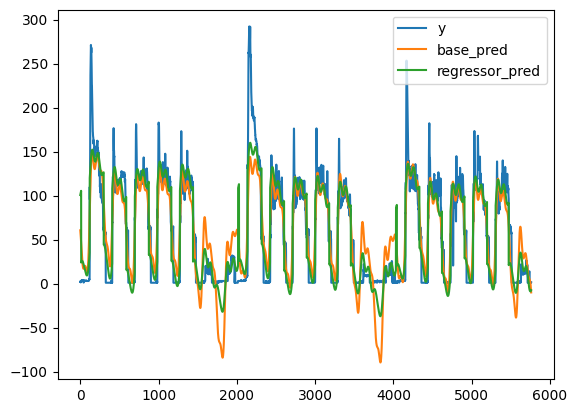

In [490]:
comp_df.plot()

To compare the two models, we use R-squared and root mean squared error (RMSE), both of which compare some aspect of the models to the actual data.

[R-squared](https://en.wikipedia.org/wiki/Coefficient_of_determination) (which I talked about in [this notebook](https://github.com/onboard-data/notebooks/blob/dev/04_timeseries_cleaning_and_imputation.ipynb)) tells us what percentage of the variance in the original data can be accounted for by the model, where 1.0 is perfect correspondence and 0.0 means the two are unrelated. In our case, both fit pretty well, but the model with the regressor accounted for 10% more variance in the actual values than did the model without the regressor. In more simple terms, the model with the `operation` regressor feature improved predictions more than the model without that extra feature.

[RMSE](https://www.statology.org/how-to-interpret-rmse/) is the more straightforward measure of model fit, quantifying the average distance between model predictions and the actual data. A lower value means the model prediction is closer to the data, and we again see that the model with the regressor is better than the one without.

We can back up these findings visually in the graph as well by comparing model predictions (orange and green lines) against the actual data (blue line). In particular, the model with the regressor predicts weekend usage quite a bit better than does the base model without a regressor. This makes sense, of course, as the difference between weekdays and weekends probably accounts for a large amount of the CHWS data variance as it relates to this `operation` feature.

## Predict Future Consumption

Now that we've seen that our `operation` feature adds something important to the model, dust off your crystal ball, drain your tea leaves, we're looking into the future! While Prophet has many intriguing uses, this is easily the more intuitive use of a program that is, according to its name, geared around predicting what will happen some time in the future.

Trend forecasting could be especially helpful, for example, in trying to avoid demand charges. If you know you have some sort of usage cap or tier system on some resource or utility, you could predict what usage will look like for some upcoming time period, and then attempt to pre-emptively account for those times where predicted usage goes over the cap.

First, we use a train/test split to assess how well this forecasting works. Train/test split is an absolutely ubiquitous technique in machine learning, a critical part of developing valid experiments. With this method, you split the data into two groups ("train" and "test" sets), train the model on the "train" set, then test the model on the "test" set. This split allows you to confirm that whatever optimization you may see during training is not just overfitted to tha dataset, and rather that it generalizes to other comparable data in the same domain. 

Here, we train the model on everything up until the last 3 days, then test on those last 3 days.

Initial log joint probability = -109.093
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      38       9276.52   0.000105753       2.89155      0.2746      0.2746       51   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


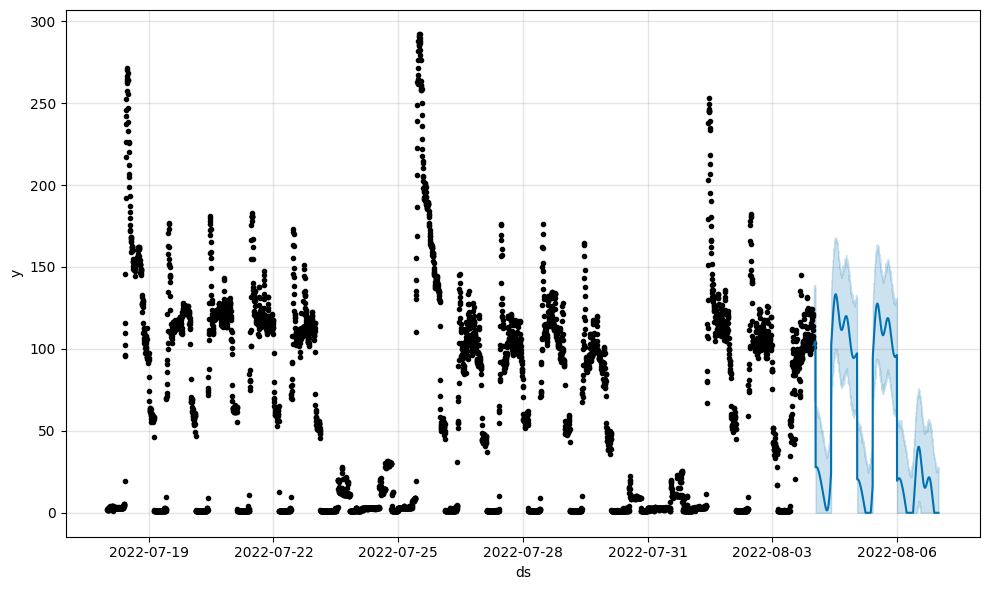

In [400]:
test_days = 3
test_period = test_days * 288 # 5-min intervals per hour * hours in a day

# everything except the last 3 days
df_train = df_prophet.iloc[:(len(df_prophet.index) - test_period)]
# the last 3 days
df_test = df_prophet.iloc[-test_period:]

# create a model
m_future = Prophet(changepoint_prior_scale=0.005,  growth='flat', yearly_seasonality=False)
m_future.add_regressor('operation', mode='multiplicative')

# train
m_future = m_future.fit(df_train)

# predict
future = m_future.predict(df_test)

# postprocess results
future.loc[future['yhat_upper'] < 1, 'yhat_upper'] = 1
future.loc[future['yhat'] < 0, 'yhat'] = 0
future.loc[future['yhat_lower'] < 0, 'yhat_lower'] = 0

fig = m_future.plot(future)

We see the model prediction seems to follow the previous data trends pretty well, most notably doing a good job of predicting the weekend day at the end there. We can now quantify this by again using R-squared to quantify how well the model works at predicting the test portion. Once again, this test/train split method works very well for model validation, to ensure the model is predicting the trends we want, and not just overfitting to data it's seen so far.

In [492]:
from sklearn.metrics import r2_score

# forecast accuracy
future.index = future.ds
future['y'] = df_test['y'].values

print(f'R-squared = {round(r2_score(future["y"], future["yhat"]), 2)}')
print(f'mean squared error = {round(mean_squared_error(future["y"], future["yhat"]),2)}')

R-squared = 0.84
mean squared error = 413.3


<AxesSubplot: xlabel='ds'>

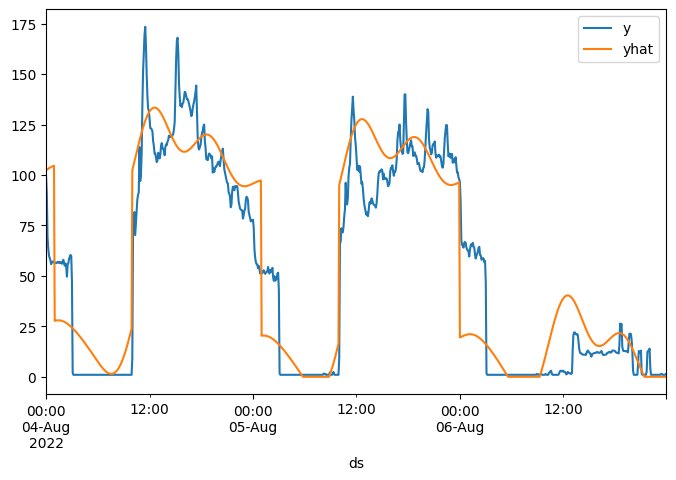

In [492]:
future[['y', 'yhat']].plot(figsize=(8,5))

Would you look at that. We get a bit higher R-squared, and, notably, a lower mean squared error than the overall model.

<img src="https://i.giphy.com/media/m2Q7FEc0bEr4I/giphy.webp" />

This is the sort of result we want to see to validate our model: the validation portion (the model's predictions for the "test" data) should do as well if not better than the overall model. So, knowing how well the predictions fit -- and having generally validated our model -- we have two main routes to choose from: further model optimization, or prediction. For model optimization, we could work on improving model fit by identfying and including more plausible features, increasing the training data, or tweaking model parameters. Otherwise, we could decide we're happy with the current model fit, and use this model to predict unforeseen data (and use those predictions to some end). 

## Model Optimization

Let's briefly take the optimization route. Here, I'll take one quick second pass, to re-sample the data to an hourly rate. Because changes in flow are likely rather volatile across 5-min increments, we are likely to see better model performance at a more coarse-grained time scale.

### Test hourly rate

This part is almost identical to the previous model we made, except taking the mean of the sensor readings across a whole hour, rather than across five-min intervals.

In [491]:
# resample from original sensor data we queried earlier
hourly_data = sensor_data.resample('60T').mean(numeric_only=True) # resample to consistent 1 hour intervals

# make our feature, operational status (operational = times between 10am-midnight, Monday-Friday)
hourly_data['hour'] = hourly_data.index.hour
hourly_data['weekday'] = hourly_data.index.weekday
hourly_data['workweek'] = hourly_data.apply(lambda x: x.weekday in [0,1,2,3,4], axis=1)
hourly_data['operation'] = hourly_data.apply(lambda x: x.workweek == True and (x.hour >= 10 or x.hour == 0), axis=1)

# now make the data frame we will feed to the model
df_prophet_hourly = hourly_data[['Chilled Water Supply Flow', 'operation']].copy()
df_prophet_hourly = df_prophet_hourly.rename(columns={"Chilled Water Supply Flow": "y"})  # CHWS Flow
df_prophet_hourly['ds'] = df_prophet_hourly.index
df_prophet_hourly['ds'] = df_prophet_hourly['ds'].dt.tz_localize(None)
df_prophet_hourly.head()

# make a model for the hourly data
hourly_model = Prophet(changepoint_prior_scale=0.005, yearly_seasonality=False)
hourly_model.add_regressor('operation', mode='multiplicative')
hourly_model = hourly_model.fit(df_prophet_hourly)

hourly_forecast = hourly_model.predict(df_prophet_hourly)
hourly_forecast['y'] = df_prophet_hourly['y'].reset_index(drop = True)

# train/test split

test_days = 3
test_period = test_days * 24 # 24 hours per day

# everything except the last 3 days
df_train_hourly = df_prophet_hourly.iloc[:(len(df_prophet_hourly.index) - test_period)]
# the last 3 days
df_test_hourly = df_prophet_hourly.iloc[-test_period:]

# create a model
m_future_hourly = Prophet(changepoint_prior_scale=0.005,  growth='flat', yearly_seasonality=False)
m_future_hourly.add_regressor('operation', mode='multiplicative')

# train
m_future_hourly = m_future_hourly.fit(df_train_hourly)

# predict
future_hourly = m_future_hourly.predict(df_test_hourly)

# postprocess results
future_hourly.loc[future_hourly['yhat_upper'] < 1, 'yhat_upper'] = 1
future_hourly.loc[future_hourly['yhat'] < 0, 'yhat'] = 0
future_hourly.loc[future_hourly['yhat_lower'] < 0, 'yhat_lower'] = 0

# forecast accuracy
future_hourly.index = future_hourly.ds
future_hourly['y'] = df_test_hourly['y'].values

In [491]:
print('')
print(f'R-squared = {round(r2_score(future_hourly["y"], future_hourly["yhat"]), 2)}')
print(f'mean squared error = {round(mean_squared_error(future_hourly["y"], future_hourly["yhat"]),2)}')

Initial log joint probability = -22.1877
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       850.295    0.00203233        952.34           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       928.975   0.000770306       1002.66           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     292       930.266   6.99145e-09       997.836      0.6633      0.6633      336   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -11.2139
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      37        784.09   0.000376348      0.263813      0.5008      0.5008       49   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below t

<AxesSubplot: xlabel='ds'>

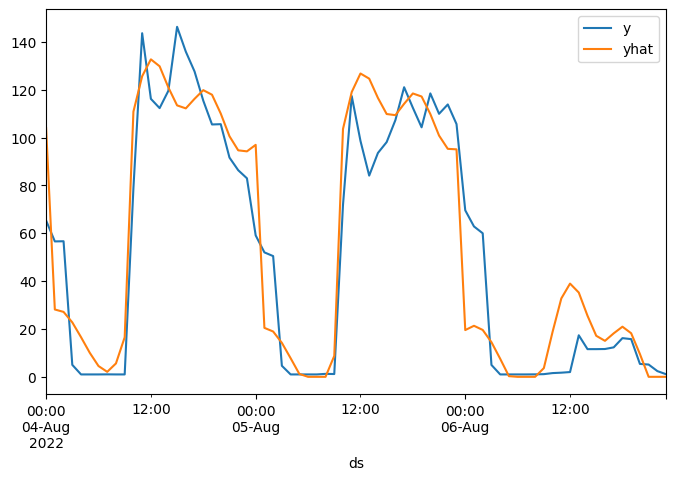

In [491]:
future_hourly[['y', 'yhat']].plot(figsize=(8,5))

Once again, we see improved model fit (higher R-squared, lower RMSE) compared to the previous 5-minute intervals model, but perhaps not as much as we might have expected. So, we again have to decide: optimize the model more, or predict future consumption? Given what we've shown so far, you should be well equipped to delve more into Prophet to be able to make any of those choices to suit your needs. As always, which path to take is as much a question of practicality as much as anything else -- tradeoffs of time spent on this project vs the diminishing returns of tweaking a model forever.

One interesting experiment (that I'll leave as an exercise for the reader): try tweaking the changepoint prior scale, and see how that effects model fit. That will give you some more insight into how this parameter affects model fit.

## Conclusion

In this article we used the feature we identified previously (business operational vs. non-op times) to forecast chilled 🤙 water supply flow using Facebook's Prophet model.

Have a chill time until I write another of these things. 🤙🥶🧘‍♀️ (three more emojis for the road! They can't hold me back, baby!)